In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

# Create learning dataset

In [ ]:
dataset = pd.read_csv("../data/ready_to_use_datasets/lesfresnes.csv")

In [ ]:
dataset["date"] = pd.to_datetime(dataset["date"])

In [ ]:
X = dataset.drop(["reference_pm25", "microsensor_pm25", "date", "season"], axis=1)

In [ ]:
X

,hourofday,monthofyear,temperature,humidity
0,0,1,13.21,99.9
1,0,1,13.21,99.9
2,0,1,12.92,99.9
3,0,1,12.92,99.9
4,0,1,13.21,99.9
...,...,...,...,...
753065,13,12,7.20,99.9
753066,13,12,7.20,99.9
753067,13,12,7.61,99.9
753068,13,12,7.61,99.9


## Scale data

In [ ]:
scaler = MinMaxScaler()
X_cols = X.columns # Store column names
continuous_variables = ["temperature", "humidity"]
X[continuous_variables] = scaler.fit_transform(X[continuous_variables])

## Construct labels

A microsensor measure is labeled wrong if the absolute difference with the reference station exceeds an arbitrarily chosen threshold.

In [ ]:
# Construct labels
threshold = 3
y = abs(dataset["reference_pm25"] - dataset["microsensor_pm25"]) >= threshold

## Split training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [ ]:
true_propor = sum(y_train) / len(y_train)
print(f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong.")

27.87% of the training measures are labeled as wrong.


In [ ]:
balancer = SMOTE()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [ ]:
true_propor = sum(y_train) / len(y_train)
print(
    f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong after the SMOTE resampling."
)

50.0% of the training measures are labeled as wrong after the SMOTE resampling.


# Single decision tree

## Train the model

In [ ]:
decision_tree = tree.DecisionTreeClassifier(max_depth=2)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

## Analyse model

### Metrics

In [ ]:
y_pred = decision_tree.predict(X_test)

In [ ]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.43753530292983617
Accuracy: 0.6927890029107443
Recall: 0.337737673219465


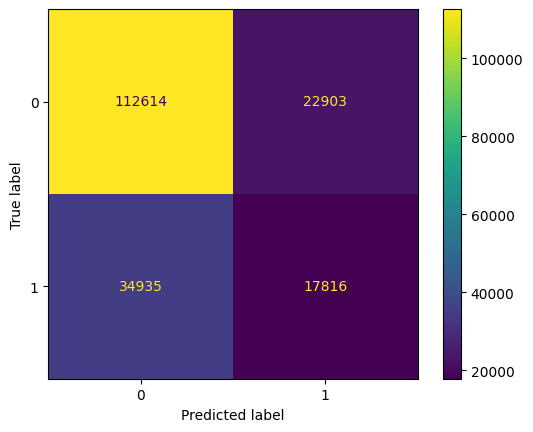

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(f"Proportion of predicted positive: {sum(y_pred) / len(y_pred)}")

Proportion of predicted positive: 0.21628210848365095


### Comparison with dummy classifier

In [ ]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_test, y_test)
dummy_pred = dummy_model.predict(X_test)
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Accuracy: {accuracy_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Precision: 0.2788728794607201
Accuracy: 0.4992245097414324
Recall: 0.4964266080263881


### Feature importance

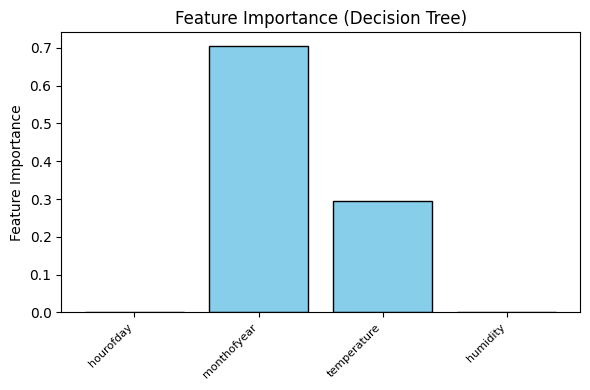

In [ ]:
feature_importances = decision_tree.feature_importances_
feature_names = X_cols

plt.figure(figsize=(6, 4))
plt.bar(
    range(len(feature_importances)),
    feature_importances,
    color="skyblue",
    edgecolor="black",
)
plt.xticks(
    range(len(feature_names)), feature_names, rotation=45, ha="right", fontsize=8
)
plt.ylabel("Feature Importance", fontsize=10)
plt.title("Feature Importance (Decision Tree)", fontsize=12)
plt.tight_layout()
plt.show()

### Plot the tree

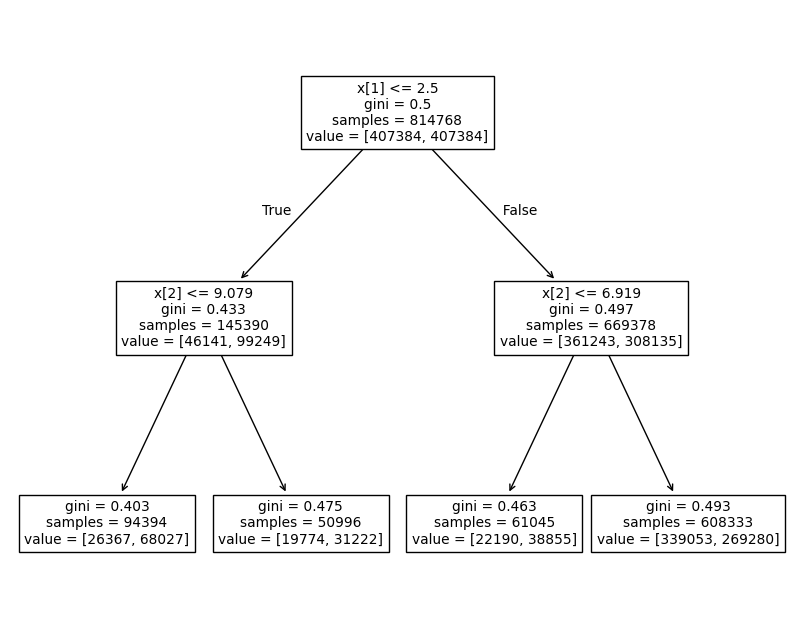

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
tree.plot_tree(decision_tree, ax=ax)
plt.show()

# XGBoost

## Train the model

### Grid search

In [ ]:
# Define parameter grid
param_grid = {
    "learning_rate": [0.1],
    "max_depth": [2, 3, 4],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.3],
    "n_estimators": [50, 100],
}

# Initialize the classifier with fixed parameters
clf = xgb.XGBClassifier(
    tree_method="hist", early_stopping_rounds=4, use_label_encoder=False
)

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1
)

grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:56:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:56:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:56:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:56:35] WARNING: /workspace/src/lea

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=4,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.3], 'learning_rate': [0.1],
                         'max_depth': [2, 3, 4], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100]},
             scoring='f1', verbose=1)

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100}
Best score: 0.6400522175719766


### Final training

In [ ]:
best_params = grid_search.best_params_
best_params["max_depth"] = 3  # Set to 3 for having nice tree plot
optimized_clf = xgb.XGBClassifier(
    tree_method="hist", early_stopping_rounds=4, **best_params
)
optimized_clf.fit(X_train, y_train, eval_set=[(X_train, y_train)])

[0]	validation_0-logloss:0.68839
[1]	validation_0-logloss:0.68448
[2]	validation_0-logloss:0.68068
[3]	validation_0-logloss:0.67791
[4]	validation_0-logloss:0.67548
[5]	validation_0-logloss:0.67306
[6]	validation_0-logloss:0.67133
[7]	validation_0-logloss:0.66947
[8]	validation_0-logloss:0.66780
[9]	validation_0-logloss:0.66639
[10]	validation_0-logloss:0.66511
[11]	validation_0-logloss:0.66427
[12]	validation_0-logloss:0.66325
[13]	validation_0-logloss:0.66235
[14]	validation_0-logloss:0.66160
[15]	validation_0-logloss:0.66103
[16]	validation_0-logloss:0.66030
[17]	validation_0-logloss:0.65984
[18]	validation_0-logloss:0.65939
[19]	validation_0-logloss:0.65802
[20]	validation_0-logloss:0.65734
[21]	validation_0-logloss:0.65678
[22]	validation_0-logloss:0.65607
[23]	validation_0-logloss:0.65525
[24]	validation_0-logloss:0.65424
[25]	validation_0-logloss:0.65357
[26]	validation_0-logloss:0.65273
[27]	validation_0-logloss:0.65209
[28]	validation_0-logloss:0.65154
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=4,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Analyse model

### Metrics

In [ ]:
y_pred = optimized_clf.predict(X_test)

In [ ]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.4200209407429988
Accuracy: 0.6557035715044511
Recall: 0.6007658622585353


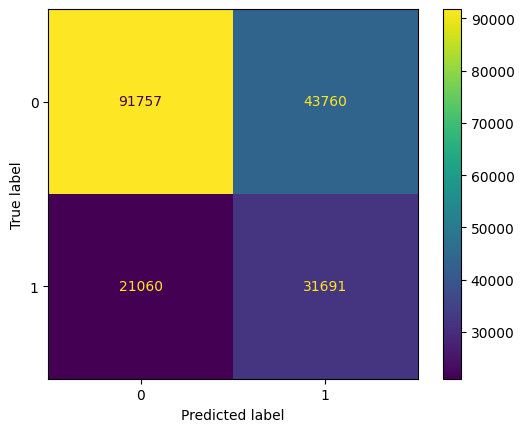

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(f"Proportion of predicted positive: {sum(y_pred) / len(y_pred)}")

Proportion of predicted positive: 0.40076380478891793


### Comparison with dummy classifier

In [ ]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_test, y_test)
dummy_pred = dummy_model.predict(X_test)
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Accuracy: {accuracy_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Precision: 0.27933536604799897
Accuracy: 0.4991607708160707
Recall: 0.4984360486057136


### Feature importance

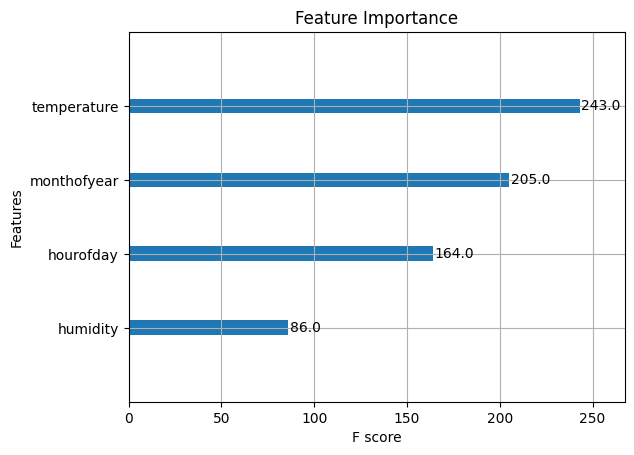

In [ ]:
xgb.plot_importance(optimized_clf, importance_type="weight")
plt.title("Feature Importance")
plt.show()

### Example of a tree

[Tree interpretation guide](https://stats.stackexchange.com/questions/395697/what-is-an-intuitive-interpretation-of-the-leaf-values-in-xgboost-base-learners)

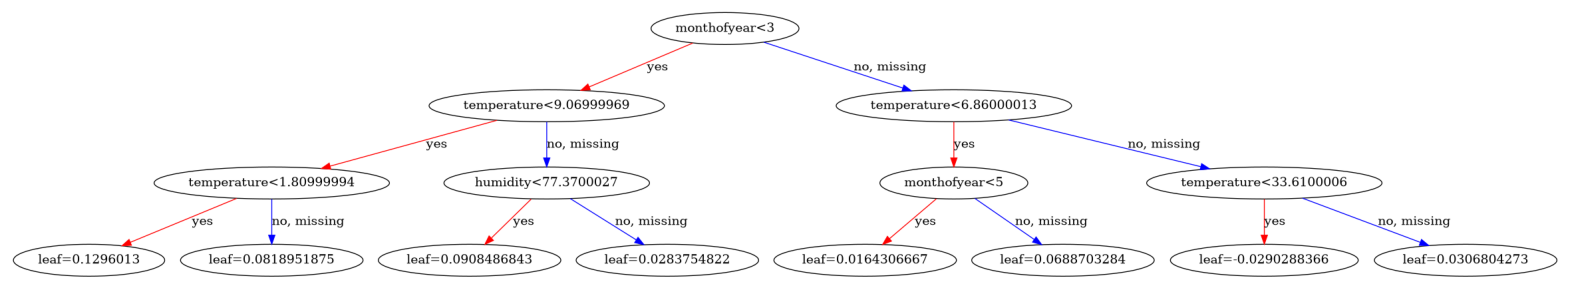

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(optimized_clf, num_trees=0, ax=ax)
plt.show()